### Generate event files and check multicollinearity

*Zizhuang Miao*

This script is used to generate event files from the consensus annotations of four experimenters. Also in the later part, the codes tested whether there is a multicollinearity problem in the design matrix. The code is on social interactions but should be very easy to be changed to theory of mind.

#### Generate event files

In [7]:
import pandas as pd
import os

dataDir = ""    # the directory of the annotations in .csv files
timingDir = ""    # the directory of the timing files from the scanning
outputDir = ""

subList = list(pd.read_csv("")['subjects'])
# subList = ['sub-0017']    # test

for sub in subList:
    for run in ['01', '02', '03', '04']:
        timingFile = timingDir + sub + "\\ses" + sub[3:] + "\\" + sub + "_ses-02_task-narratives_run-" + run + "_beh.csv"
        if not os.path.isfile(timingFile):
            print(f'There is no behavior timing file for {sub} run-{run}!')
            continue
        timing = pd.read_csv(timingFile)    # behavior timing file for this run
        runStart = timing.loc[0, 'event01_fixation_onset']
        Stim = []
        Onset = []
        Duration = []
        if run == '01' or run == '02':
            socStr = 'SocInt_audio'
            notsocStr = 'noSocInt_audio'
        else:
            socStr = 'SocInt_text'
            notsocStr = 'noSocInt_text'
        
        for i in range(len(timing)):
            chunkName = timing.loc[i, 'param_stimulus_filename'][:20]
            trialStart = timing.loc[i, 'event02_administer_onset']    # when stimuli began to present
            annot = pd.read_csv(dataDir + chunkName + "_transcript_annotated.csv")    # annotated word-by-word text
            if annot.loc[0, 'socialInteraction'] == 0:    # this trial starts with not social
                Stim.append(notsocStr)
                soc_boolean = 0
            else:
                Stim.append(socStr)
                soc_boolean = 1
            Onset.append(trialStart - runStart)
            
            for j in range(1, len(annot)):
                if annot.loc[j, 'socialInteraction'] != annot.loc[j-1, 'socialInteraction']:
                    if soc_boolean == 0:    # not social previously, and social now
                        Stim.append(socStr)
                    else:    # social previously, not social now
                        Stim.append(notsocStr)
                    soc_boolean = 1 - soc_boolean
                    Onset.append(annot.loc[j, 'onset'] + trialStart - runStart)
                    Duration.append(Onset[-1] - Onset[-2])
            
            ratingStart = timing.loc[i, 'event03_feel_displayonset']
            Duration.append(ratingStart - (Onset[-1] + runStart))
            Stim.append('rating')
            Onset.append(ratingStart - runStart)
            Duration.append(8)
    
        eventDf = pd.DataFrame({'Stim': Stim, 'Onset': Onset, 'Duration': Duration})
        if sub == 'sub-0017':
            durSoc = sum(eventDf[eventDf.Stim == socStr]['Duration'])
            durnotSoc = sum(eventDf[eventDf.Stim == notsocStr]['Duration'])
            print(f'The whole duration of run-{run} is {Onset[-1]+Duration[-1]:.2f} seconds.')
            print(f'The whole duration of narratives is {durSoc+durnotSoc:.2f} seconds.')
            print(f'The duration of social interaction is {durSoc:.2f} seconds, which takes {durSoc*100/(durSoc+durnotSoc):.2f}% of the narratives duration.')
        outputFile = outputDir + sub + "_run-" + run + "_social_manual.csv"
        eventDf.to_csv(outputFile, header=True, index=False)

There is no behavior timing file for sub-0011 run-02!
The whole duration of run-01 is 439.76 seconds.
The whole duration of narratives is 233.02 seconds.
The duration of social interaction is 170.87 seconds, which takes 73.33% of the narratives duration.
The whole duration of run-02 is 499.36 seconds.
The whole duration of narratives is 293.82 seconds.
The duration of social interaction is 177.44 seconds, which takes 60.39% of the narratives duration.
The whole duration of run-03 is 591.34 seconds.
The whole duration of narratives is 400.73 seconds.
The duration of social interaction is 209.46 seconds, which takes 52.27% of the narratives duration.
The whole duration of run-04 is 525.88 seconds.
The whole duration of narratives is 325.31 seconds.
The duration of social interaction is 146.93 seconds, which takes 45.17% of the narratives duration.
There is no behavior timing file for sub-0038 run-03!
There is no behavior timing file for sub-0069 run-03!


#### Check Multicollinearity

In [1]:
# run this cell first to get the VIF function
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from nltools.data import Design_Matrix
from nltools.file_reader import onsets_to_dm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# define a function to calculate VIF for each column
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

##### 1. Original regressors (SInt_audio, NSoc_audio, SInt_text, and NSoc_text)

            SInt_audio  SInt_text  NSoc_audio  NSoc_text    Rating
SInt_audio    1.000000  -0.212510   -0.090643  -0.222848 -0.261707
SInt_text    -0.212510   1.000000   -0.154651  -0.167455 -0.275099
NSoc_audio   -0.090643  -0.154651    1.000000  -0.162174 -0.198625
NSoc_text    -0.222848  -0.167455   -0.162174   1.000000 -0.295466
Rating       -0.261707  -0.275099   -0.198625  -0.295466  1.000000
            SInt_audio  SInt_text  NSoc_audio  NSoc_text    Rating
SInt_audio    1.000000  -0.191850   -0.045914  -0.201626 -0.317812
SInt_text    -0.191850   1.000000   -0.141094  -0.160925 -0.307785
NSoc_audio   -0.045914  -0.141094    1.000000  -0.148284 -0.275898
NSoc_text    -0.201626  -0.160925   -0.148284   1.000000 -0.361451
Rating       -0.317812  -0.307785   -0.275898  -0.361451  1.000000


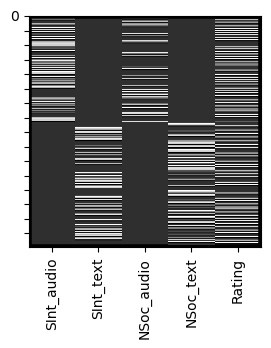

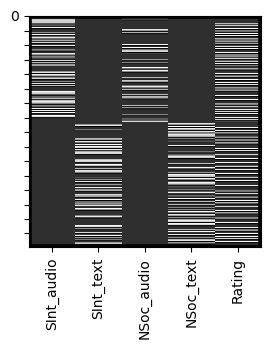

In [15]:
eventsDir = ""

tr = 0.46

for sub in ['sub-0080', 'sub-0081']:    # two possible sequences, thus two possible design matrices
    allDm = Design_Matrix(sampling_freq = 1/tr)
    allDmCon = Design_Matrix(sampling_freq = 1/tr)
    for run in ['01', '02', '03', '04']:
        eventsFile = pd.read_csv(os.path.join(eventsDir, f'{sub}_ses-02_task-narratives_run-{run}_socialIntearctionEvents_Zizhuang.csv'))
        runLength = round((eventsFile.loc[eventsFile.Stim=="rating", "Onset"].iloc[-1] + eventsFile.loc[eventsFile.Stim=="rating", "Duration"].iloc[-1])/tr)
        dm = onsets_to_dm(eventsFile, sampling_freq=1/tr, run_length=runLength)
        allDm = allDm.append(dm, axis=0)
        dmCon = dm.convolve()
        allDmCon = allDmCon.append(dmCon, axis=0)
    allDm.columns = ['SInt_audio', 'SInt_text', 'NSoc_audio', 'NSoc_text', 'Rating']
    allDmCon.columns = ['SInt_audio', 'SInt_text', 'NSoc_audio', 'NSoc_text', 'Rating']
    allDmCon.heatmap(figsize=(3,3))
    
print(allDm.corr())
print(allDmCon.corr())

In [6]:
print('The VIF values of the original design matrix are as follows:')
print(calculate_vif(allDmCon))

The VIF values of the original design matrix are as follows:
     Variable       VIF
0  SInt_audio  1.009733
1   SInt_text  1.003502
2  NSoc_audio  1.012751
3   NSoc_text  1.007895
4      Rating  1.018694


##### 2. Merge two conditions into one

           SInt      NSoc    Rating
SInt    1.00000 -0.398280 -0.427790
NSoc   -0.39828  1.000000 -0.386937
Rating -0.42779 -0.386937  1.000000
            SInt      NSoc    Rating
SInt    1.000000 -0.337494 -0.501368
NSoc   -0.337494  1.000000 -0.500738
Rating -0.501368 -0.500738  1.000000


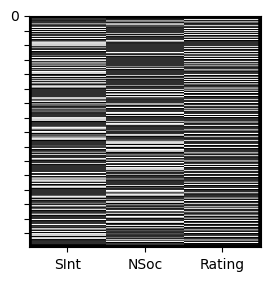

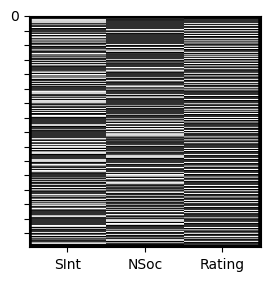

In [16]:
eventsDir = ""

tr = 0.46

for sub in ['sub-0080', 'sub-0081']:    # two possible sequences, thus two possible design matrices
    allDm = Design_Matrix(sampling_freq = 1/tr)
    allDmCon = Design_Matrix(sampling_freq = 1/tr)
    
    for run in ['01', '02', '03', '04']:
        eventsFile = pd.read_csv(os.path.join(eventsDir, f'{sub}_ses-02_task-narratives_run-{run}_socialIntearctionEvents_Zizhuang.csv'))
        runLength = round((eventsFile.loc[eventsFile.Stim=="rating", "Onset"].iloc[-1] + eventsFile.loc[eventsFile.Stim=="rating", "Duration"].iloc[-1])/tr)
        dm = onsets_to_dm(eventsFile, sampling_freq=1/tr, run_length=runLength)
        allDm = allDm.append(dm, axis=0)
    
    # merge the two regressors in two conditions to one
    allDm.loc[allDm.SocInt_text==1, "SocInt_audio"] = 1
    allDm.loc[allDm.noSocInt_text==1, "noSocInt_audio"] = 1
    allDm.drop(["noSocInt_text", "SocInt_text"], axis=1, inplace=True)

    allDmCon = allDm.convolve()
    allDm.columns = ['SInt', 'NSoc', 'Rating']
    allDmCon.columns = ['SInt', 'NSoc', 'Rating']
    allDmCon.heatmap(figsize=(3,3))
    
print(allDm.corr())
print(allDmCon.corr())

In [21]:
print('The VIF values of the original design matrix are as follows:')
print(calculate_vif(allDmCon))

The VIF values of the original design matrix are as follows:
  Variable       VIF
0     SInt  1.008730
1     NSoc  1.016261
2   Rating  1.020316
